## Import librairies

In [1]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer
from sklearn.model_selection import GridSearchCV

pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [2]:
# Aide sur la fonction
load_digits?

Signature: load_digits(*, n_class=10, return_X_y=False, as_frame=False)
Docstring:
Load and return the digits dataset (classification).

Each datapoint is a 8x8 image of a digit.

=================   ==============
Classes                         10
Samples per class             ~180
Samples total                 1797
Dimensionality                  64
Features             integers 0-16
=================   ==============

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

Read more in the :ref:`User Guide <digits_dataset>`.

Parameters
----------
n_class : int, default=10
    The number of classes to return. Between 0 and 10.

return_X_y : bool, default=False
    If True, returns ``(data, target)`` instead of a Bunch object.
    See below for more information about the `data` and `target` object.

    .. versionadded:: 0.18

as_frame : bool, default=False
    If True, the data is a

In [3]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [4]:
data.head(20)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
5,0.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,16.0,16.0,14.0,0.0,0.0,0.0,0.0,13.0,16.0,15.0,10.0,1.0,0.0,0.0,0.0,11.0,16.0,16.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,16.0,7.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,9.0,0.0,0.0,0.0,5.0,4.0,12.0,16.0,4.0,0.0,0.0,0.0,9.0,16.0,16.0,10.0,0.0,0.0,5
6,0.0,0.0,0.0,12.0,13.0,0.0,0.0,0.0,0.0,0.0,5.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,13.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,12.0,7.0,2.0,0.0,0.0,0.0,0.0,13.0,16.0,13.0,16.0,3.0,0.0,0.0,0.0,7.0,16.0,11.0,15.0,8.0,0.0,0.0,0.0,1.0,9.0,15.0,11.0,3.0,0.0,6
7,0.0,0.0,7.0,8.0,13.0,16.0,15.0,1.0,0.0,0.0,7.0,7.0,4.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,8.0,13.0,1.0,0.0,0.0,4.0,8.0,8.0,15.0,15.0,6.0,0.0,0.0,2.0,11.0,15.0,15.0,4.0,0.0,0.0,0.0,0.0,0.0,16.0,5.0,0.0,0.0,0.0,0.0,0.0,9.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,5.0,0.0,0.0,0.0,0.0,7
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,12.0,14.0,14.0,12.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,15.0,4.0,0.0,0.0,0.0,3.0,16.0,12.0,14.0,2.0,0.0,0.0,0.0,4.0,16.0,16.0,2.0,0.0,0.0,0.0,3.0,16.0,8.0,10.0,13.0,2.0,0.0,0.0,1.0,15.0,1.0,3.0,16.0,8.0,0.0,0.0,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8
9,0.0,0.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,16.0,16.0,13.0,0.0,0.0,0.0,3.0,16.0,12.0,10.0,14.0,0.0,0.0,0.0,1.0,16.0,1.0,12.0,15.0,0.0,0.0,0.0,0.0,13.0,16.0,9.0,15.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,0.0,9.0,15.0,4.0,0.0,0.0,0.0,9.0,12.0,13.0,3.0,0.0,0.0,9


Infos sur le dataset : Chaque X représente un pixel (une partie de l'image) et l'idée est de reconstituer l'ensemble des pixels pour retrouver l'image du chiffre. L'image est sous format 8x8. Et donc on a 64 pixels pour chaque image donc des Xi i = 0, 1, 2, ..., 63

In [5]:
data.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,10.382304,11.979410,10.279354,8.175849,1.846411,0.107958,0.002782,2.601558,9.903172,6.992766,7.097941,7.806344,1.788536,0.050083,0.001113,2.469672,9.091263,8.821369,9.927101,7.551475,2.317752,0.002226,0.0,2.339455,7.667223,9.071786,10.301614,8.744018,2.909293,0.0,0.008904,1.583751,6.881469,7.228158,7.672231,8.236505,3.456316,0.027268,0.007234,0.704508,7.506956,9.539232,9.416249,8.758486,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,5.421456,3.977543,4.782681,6.052960,3.586321,0.827915,0.062368,3.576301,5.690767,5.802662,6.175729,6.197322,3.259870,0.438597,0.033352,3.146532,6.192038,5.882936,6.152093,5.872556,3.686456,0.047140,0.0,3.480372,6.324687,6.268391,5.933490,5.870648,3.537283,0.0,0.145185,2.981816,6.537955,6.441378,6.259511,5.695527,4.330951,0.307356,0.204223,1.746153,5.644496,5.226948,5.302048,6.031154,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,9.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.000000,6.000000,3.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,12.000000,13.000000,11.000000,9.000000,0.000000,0.000000,0.000000,1.000000,12.000000,6.000000,6.000000,8.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,12.000000,7.000000,0.000000,0.000000,0.0,0.000000,8.000000,10.000000,13.000000,10.000000,1.000000,0.0,0.000000,0.000000,6.000000,7.000000,8.000000,9.000000,1.000000,0.000000,0.000000,0.000000,8.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.

## EDA

C:\Users\HP\AppData\Local\Temp\ipykernel_10720\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


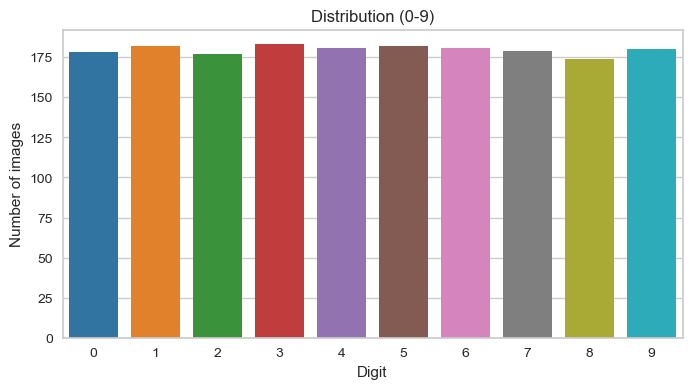

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

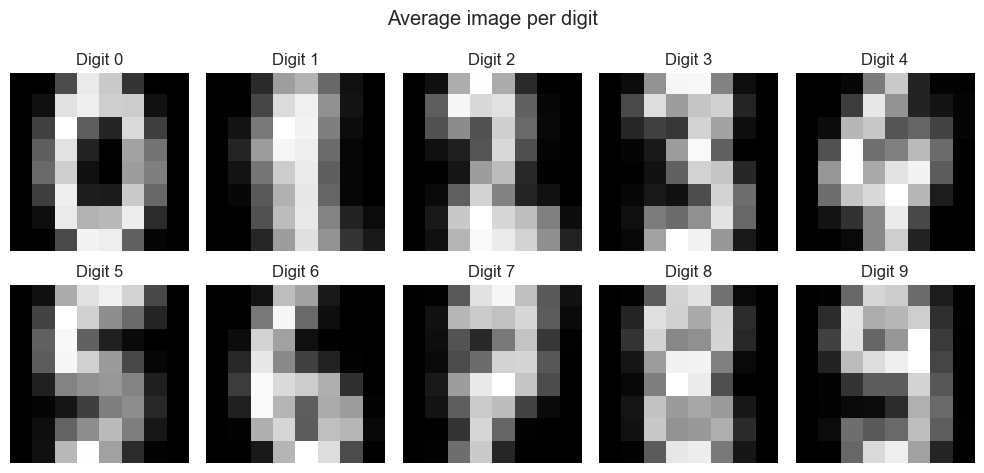

In [7]:
# mean by digit
# On ne pas calculer les 1700 images, mais on calcule la moyenne des images
# Pour chaque chiffre par exemple on prend l'image moyen (calculé à parit des vecteurs 
# des images de chaque catégories) qui permet de décrire le chiffre.
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)
# Pour chaque variable, on calcule le pixel moyenne pour les mêmes chiffres

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()
# Les résultats montrent l'image moyen pour chaque chiffre

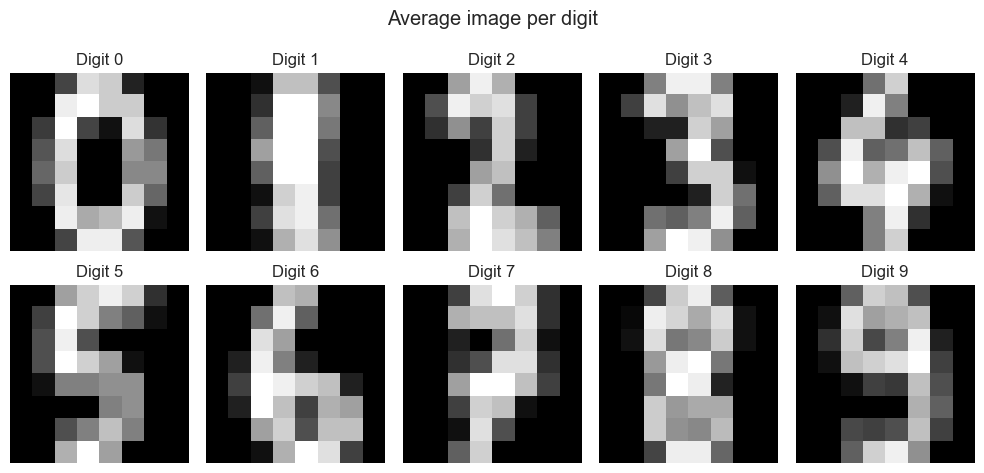

In [8]:
# median by digit
# Prendre la valeur minimum de chaque image
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].median(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()
# Les résultats montrent l'image moyen pour chaque chiffre

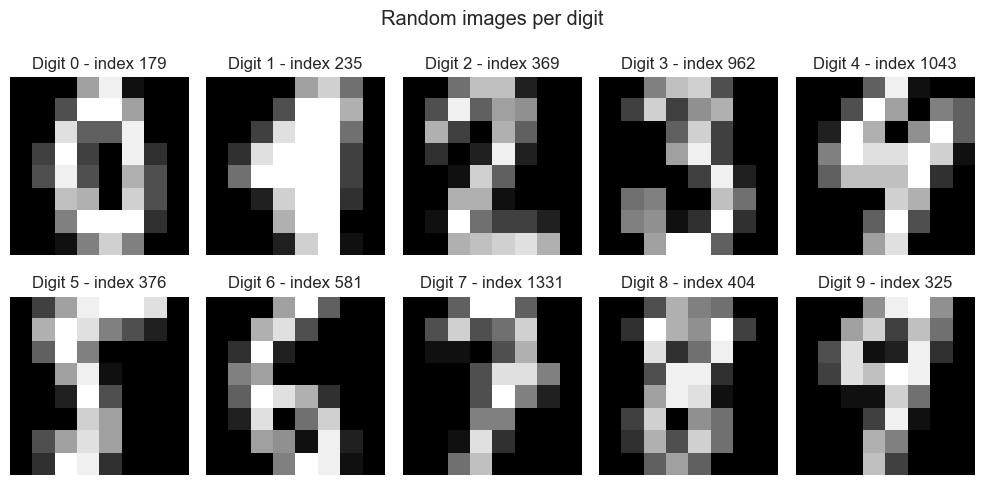

In [9]:
# On peut aussi choisir une image au hazard pour représenter chaque catégorie 
# au lieu de prendre l'image moyenne
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

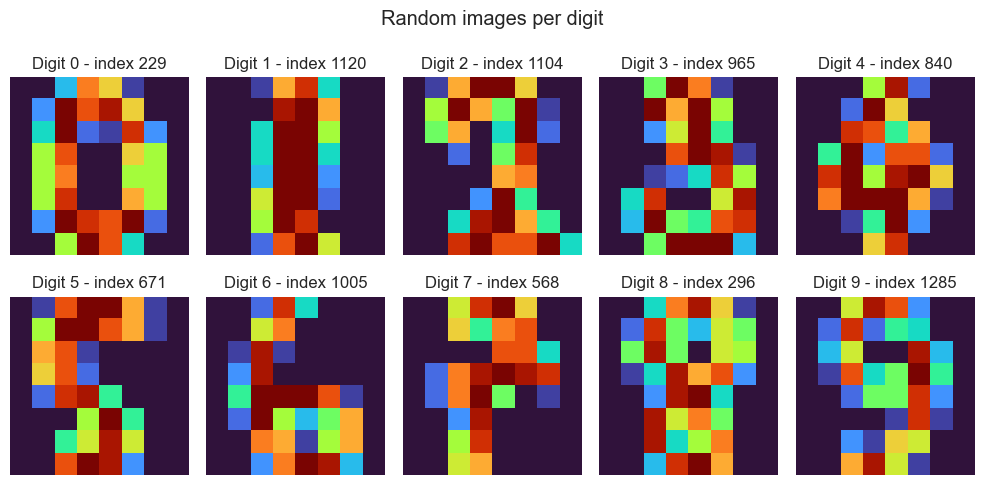

In [10]:
# Affichage des images en couleurs avec turbo : RGB
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='turbo')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [11]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=500,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results

### Run benchmark

Globalement, les modèles sans l'ACP donne de meilleurs scores par rapport aux métriques de performance (ARI, homogeneity, completness et v-measure).

In [12]:
param_grid = {
    'n_clusters' : range(2, 15),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500]
}

#### Tuning hyperparameters and optimal number of clusters (without PCA)

In [13]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means(kmeans, name=init, data=X, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}
print("_" * 82)
print("Best hyperparameters :")
print(best_params)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.372s	7596	0.232	0.860	0.366	0.139	0.118
k-means++	0.062s	6877	0.313	0.661	0.425	0.237	0.125
k-means++	0.078s	6405	0.366	0.611	0.458	0.288	0.136
k-means++	0.078s	5976	0.460	0.701	0.555	0.349	0.133
k-means++	0.109s	5597	0.522	0.693	0.595	0.430	0.147
k-means++	0.149s	5324	0.573	0.700	0.630	0.478	0.156
k-means++	0.125s	5039	0.673	0.770	0.719	0.581	0.184
k-means++	0.187s	4793	0.693	0.752	0.721	0.598	0.188
k-means++	0.187s	4648	0.740	0.750	0.745	0.665	0.175
k-means++	0.172s	4520	0.746	0.729	0.738	0.648	0.173
k-means++	0.187s	4402	0.804	0.756	0.779	0.733	0.174
k-means++	0.203s	4274	0.816	0.743	0.778	0.712	0.173
k-means++	0.203s	4180	0.812	0.720	0.763	0.672	0.187
k-means++	0.062s	7596	0.232	0.860	0.366	0.139	0.120
k-means++	0.094s	6877	0.313	0.661	0.425	0.237	0.130
k-means++	0.109s	6405	0.366	0.611	0.458	0.288	0.122
k-means++	0.125s	5976	0.460	0.701

In [14]:
best_param_grid = best_params
print(best_param_grid)

{'n_clusters': 11, 'init': 'k-means++', 'n_init': 20, 'max_iter': 300}


#### Tuning hyperparamtres and optimal number of clusters (with PCA)

In [15]:
# Renvoie les composantes qui donnent 95% de l'information contenue dans les données
pca = PCA(n_components=0.95).fit(X)
print(pca.n_components_) # afficher le nombre de composantes princicipales qui donnent 95% de l'inertie totale
# print(n_digits)

29


In [16]:
X_pca = pca.transform(X) # Appliquer l'ACP sur les données
X_pca.shape, X.shape # Comparer les dimensions initiales et finales

((1797, 29), (1797, 64))

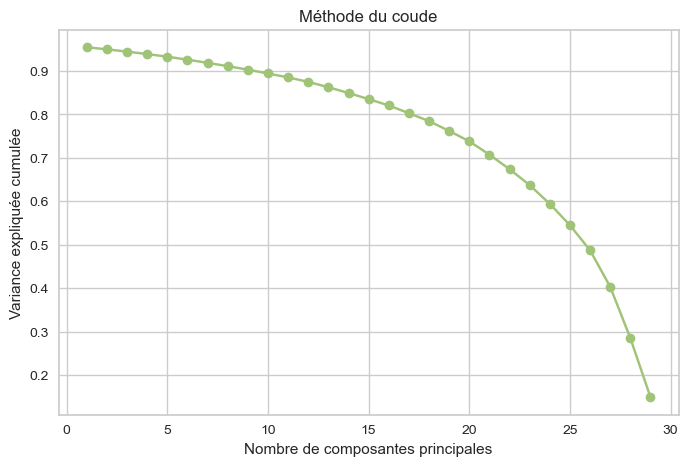

In [17]:
inertie = pca.explained_variance_ratio_

# Variance expliquée cumulée
inertie_cum = np.cumsum(inertie)
inertie_cum = np.sort(inertie_cum)[::-1]

# Tracé de la courbe
k_inertie = range(1, len(inertie_cum) + 1)
plt.figure(figsize=(8, 5))
plt.plot(k_inertie, inertie_cum, 'go-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Méthode du coude')
plt.grid(True)
plt.show()

Les hyperparamètres utilisés sont : 
- 

In [18]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means(kmeans, name=init, data=X_pca, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.064s	1181	0.230	0.856	0.362	0.138	0.126
k-means++	0.062s	1126	0.306	0.645	0.415	0.226	0.126
k-means++	0.103s	1084	0.387	0.690	0.496	0.284	0.121
k-means++	0.109s	1043	0.483	0.728	0.581	0.378	0.146
k-means++	0.124s	1008	0.531	0.721	0.611	0.415	0.154
k-means++	0.157s	975	0.619	0.770	0.687	0.501	0.164
k-means++	0.134s	950	0.696	0.790	0.740	0.618	0.196
k-means++	0.125s	924	0.719	0.774	0.746	0.637	0.201
k-means++	0.125s	903	0.773	0.781	0.777	0.715	0.184
k-means++	0.141s	887	0.746	0.731	0.739	0.642	0.197
k-means++	0.172s	866	0.781	0.732	0.756	0.676	0.193
k-means++	0.141s	850	0.800	0.729	0.763	0.680	0.176
k-means++	0.172s	840	0.806	0.719	0.760	0.681	0.181
k-means++	0.047s	1181	0.230	0.856	0.362	0.138	0.127
k-means++	0.062s	1126	0.306	0.645	0.415	0.226	0.123
k-means++	0.094s	1084	0.387	0.690	0.496	0.284	0.128
k-means++	0.109s	1043	0.483	0.728	0.581	0

In [19]:
best_param_grid = best_params
print(best_param_grid)

{'n_clusters': 11, 'init': 'k-means++', 'n_init': 20, 'max_iter': 300}


### Scaling

#### Without scaling

In [20]:
def bench_k_means_simple(kmeans, name, data, labels):

    t0 = time()
    estimator = make_pipeline(kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=500,
        )
    ]
    

    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))
    return results

In [21]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=11, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.172s	1131724	0.787	0.763	0.775	0.726	0.181
k-means++	0.187s	1131724	0.787	0.763	0.775	0.726	0.191
k-means++	0.219s	1131724	0.787	0.763	0.775	0.726	0.183
k-means++	0.219s	1131724	0.787	0.763	0.775	0.726	0.185
k-means++	0.197s	1131724	0.787	0.763	0.775	0.726	0.176
k-means++	0.203s	1131724	0.787	0.763	0.775	0.726	0.181
k-means++	0.187s	1131724	0.787	0.763	0.775	0.726	0.177
k-means++	0.188s	1131724	0.787	0.763	0.775	0.726	0.189
k-means++	0.187s	1131724	0.787	0.763	0.775	0.726	0.178
k-means++	0.172s	1131724	0.787	0.763	0.775	0.726	0.191
k-means++	0.203s	1131724	0.787	0.763	0.775	0.726	0.171
k-means++	0.219s	1131724	0.787	0.763	0.775	0.726	0.184
k-means++	0.219s	1131724	0.787	0.763	0.775	0.726	0.172
k-means++	0.187s	1131724	0.787	0.763	0.775	0.726	0.181
k-means++	0.219s	1131724	0.787	0.763	0.775	0.726	0.188
k-means++	0.203s	1131724	0.787	0.763	0.7

In [22]:
best_param_grid_simple = best_params_simple
print(best_param_grid_simple)

{'n_clusters': 2, 'init': 'random', 'n_init': 10, 'max_iter': 300}


#### MinMaxScaler

In [23]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X_scaled, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.048s	7596	0.232	0.860	0.366	0.139	0.116
k-means++	0.094s	6877	0.313	0.661	0.425	0.237	0.118
k-means++	0.062s	6405	0.366	0.611	0.458	0.288	0.124
k-means++	0.094s	5976	0.460	0.701	0.555	0.349	0.129
k-means++	0.094s	5597	0.522	0.693	0.595	0.430	0.151
k-means++	0.125s	5324	0.573	0.700	0.630	0.478	0.154
k-means++	0.109s	5039	0.673	0.770	0.719	0.581	0.181
k-means++	0.165s	4793	0.693	0.752	0.721	0.598	0.189
k-means++	0.172s	4648	0.740	0.750	0.745	0.665	0.174
k-means++	0.125s	4520	0.746	0.729	0.738	0.648	0.183
k-means++	0.172s	4402	0.804	0.756	0.779	0.733	0.176
k-means++	0.156s	4274	0.816	0.743	0.778	0.712	0.183
k-means++	0.172s	4180	0.812	0.720	0.763	0.672	0.175
k-means++	0.062s	7596	0.232	0.860	0.366	0.139	0.112
k-means++	0.078s	6877	0.313	0.661	0.425	0.237	0.123
k-means++	0.094s	6405	0.366	0.611	0.458	0.288	0.130
k-means++	0.109s	5976	0.460	0.701

In [25]:
best_params_minmax = best_params_simple
print(best_params_minmax)

{'n_clusters': 11, 'init': 'k-means++', 'n_init': 20, 'max_iter': 300}


#### StandardScaler

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X_scaled, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.102s	100424	0.185	0.644	0.288	0.127	0.103
k-means++	0.103s	93842	0.297	0.628	0.403	0.223	0.111
k-means++	0.109s	89214	0.372	0.626	0.466	0.297	0.096
k-means++	0.156s	85096	0.378	0.609	0.467	0.294	0.102
k-means++	0.180s	81678	0.476	0.642	0.547	0.359	0.111
k-means++	0.156s	77749	0.486	0.628	0.548	0.382	0.126
k-means++	0.172s	74854	0.581	0.697	0.634	0.469	0.138
k-means++	0.196s	72030	0.583	0.660	0.619	0.462	0.129
k-means++	0.187s	69814	0.650	0.694	0.671	0.534	0.141
k-means++	0.219s	67262	0.674	0.692	0.683	0.542	0.163
k-means++	0.227s	65032	0.673	0.684	0.679	0.551	0.151
k-means++	0.234s	62763	0.673	0.683	0.678	0.551	0.156
k-means++	0.250s	61963	0.692	0.686	0.689	0.567	0.150
k-means++	0.094s	100424	0.185	0.644	0.288	0.127	0.104
k-means++	0.109s	93842	0.297	0.628	0.403	0.223	0.107
k-means++	0.109s	89214	0.372	0.626	0.466	0.297	0.090
k-means++	0.156

In [28]:
best_params_standard = best_params_simple
print(best_params_standard)

{'n_clusters': 13, 'init': 'random', 'n_init': 10, 'max_iter': 300}


#### Robust Scaler

In [29]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

best_score = -1
best_params = None

for init in param_grid['init']:
    for n_init in param_grid['n_init']:
        for max_iter in param_grid['max_iter']:
            for n_clusters in param_grid['n_clusters']:
                kmeans = KMeans(n_clusters=n_clusters, 
                                init=init, 
                                n_init=n_init, 
                                max_iter=max_iter, 
                                random_state=42)
                results = bench_k_means_simple(kmeans, name=init, data=X_scaled, labels=labels)
                ari = results[6]
                if ari > best_score:
                    best_score = ari
                    best_params_simple = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'max_iter': max_iter}

print("_" * 82)
print("Best hyperparameters :")
print(best_params_simple)
print(f"Meilleur score avec ARI : {best_score:.3f}")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.056s	68374	0.042	0.288	0.074	0.011	0.391
k-means++	0.097s	59272	0.074	0.280	0.117	0.017	0.325
k-means++	0.125s	54480	0.180	0.403	0.249	0.097	0.139
k-means++	0.156s	50439	0.237	0.413	0.301	0.141	0.151
k-means++	0.109s	47106	0.213	0.337	0.261	0.109	0.161
k-means++	0.141s	44252	0.258	0.365	0.302	0.148	0.147
k-means++	0.141s	42395	0.268	0.367	0.310	0.151	0.143
k-means++	0.156s	40746	0.314	0.395	0.350	0.166	0.137
k-means++	0.172s	39073	0.356	0.399	0.376	0.224	0.136
k-means++	0.203s	37502	0.381	0.411	0.395	0.237	0.137
k-means++	0.187s	36309	0.435	0.446	0.440	0.293	0.143
k-means++	0.203s	35455	0.454	0.454	0.454	0.287	0.136
k-means++	0.203s	34528	0.460	0.440	0.450	0.298	0.138
k-means++	0.047s	68374	0.042	0.288	0.074	0.011	0.395
k-means++	0.109s	59272	0.074	0.280	0.117	0.017	0.361
k-means++	0.141s	54480	0.180	0.403	0.249	0.097	0.157
k-means++	0.156s	

In [31]:
best_params_standard = best_params_simple
print(best_params_standard)

{'n_clusters': 14, 'init': 'random', 'n_init': 10, 'max_iter': 300}


## Profiling: cluster persona


Pour optimiser les hyperparamètres du modèle KMeans, nous avons utilisé l'Adjusted Rand Index (ARI) comme critère d’évaluation.
Contrairement aux métriques internes (comme le WCSS ou le silhouette score), l’ARI permet de comparer le clustering obtenu à une partition de référence (label), en tenant compte du hasard. Comme nous disposons de classes connues permettant de valider objectivement la qualité du regroupement, il semble pertinent de l'utiliser.
L’ARI fournit une mesure robuste et interprétable de la cohérence entre la structure prédite et la structure réelle des données.

In [32]:
"""
Best hyperparameters :
{'n_clusters': 11, 'init': 'k-means++', 'n_init': 20, 'max_iter': 300}
Meilleur score avec ARI : 0.734
"""

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kmeans_final = KMeans(n_clusters=11, 
                      init='k-means++', 
                      max_iter=300, 
                      n_init=20)

kmeans_final.fit(X_scaled)

kmean_labels = kmeans_final.labels_

In [33]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,5
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,8
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,9
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,7
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,1


In [34]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,24,150,1,0,0,0,0,3,0
1,1,0,0,0,162,1,0,0,0,0
2,0,2,0,0,0,2,176,0,1,0
3,0,1,0,2,0,139,0,5,5,6
4,0,0,2,7,7,0,0,170,2,8
5,177,0,1,0,0,0,1,0,0,0
6,0,0,3,10,0,39,0,0,14,142
7,0,1,6,156,0,1,0,0,0,3
8,0,101,1,0,5,0,3,0,10,0


In [35]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0     2
1     4
2     6
3     5
4     7
5     0
6     9
7     3
8     1
9     8
10    1
dtype: int32


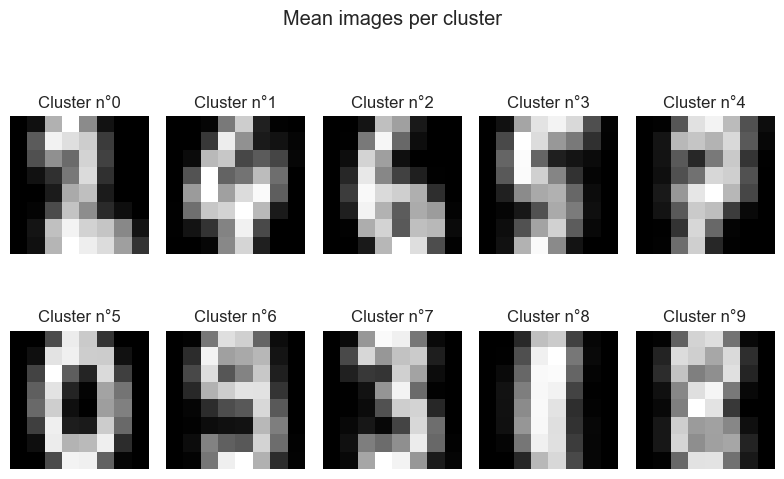

In [36]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

In [37]:
persona_summary = data.groupby('cluster').mean()
# print(persona_summary)

### Visualization with PCA

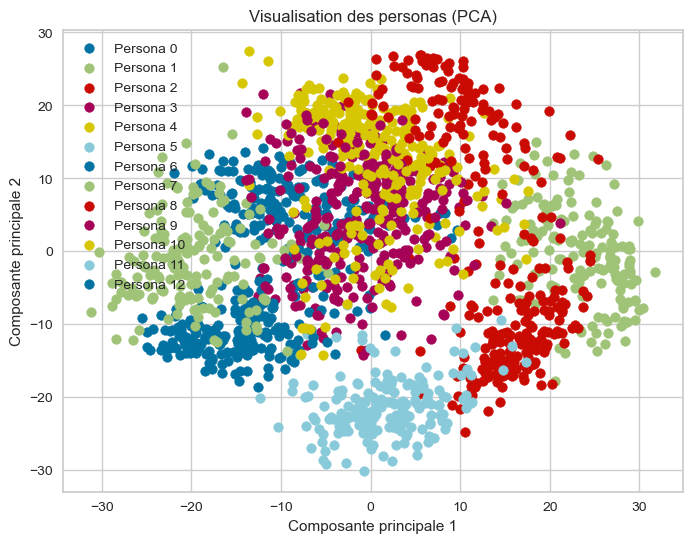

In [38]:
data['pca1'] = X_pca[:, 0]
data['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
for cluster in range(13):
    plt.scatter(data[data['cluster'] == cluster]['pca1'],
                data[data['cluster'] == cluster]['pca2'],
                label=f'Persona {cluster}')
plt.legend()
plt.title("Visualisation des personas (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

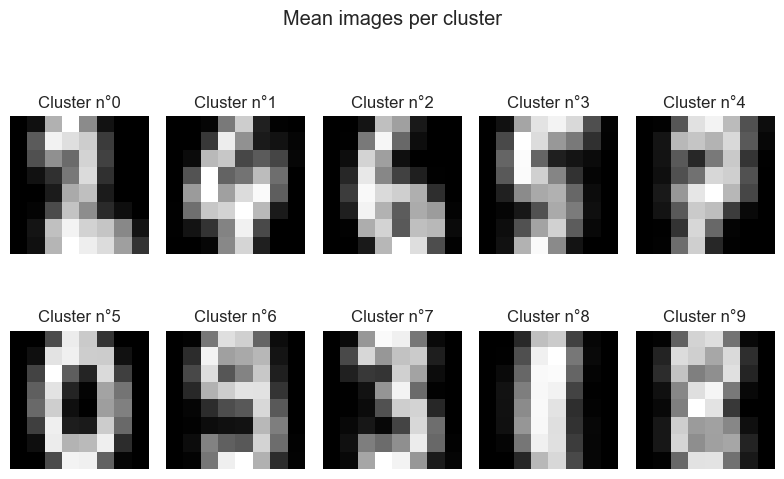

In [39]:
# Image sur les centroides (image moyen)
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Intercluster Distance Maps

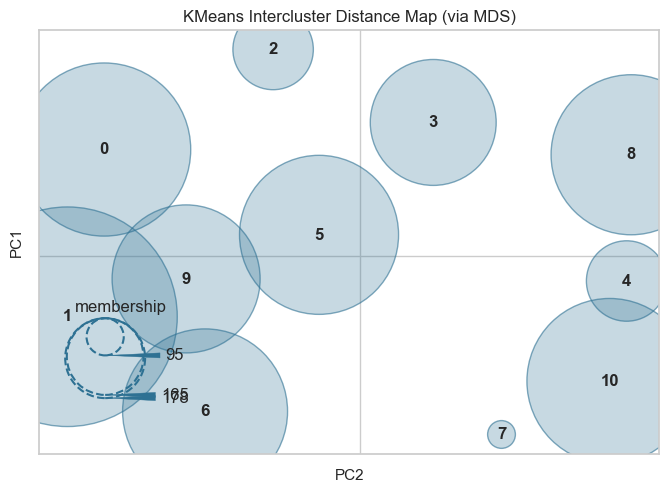

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [40]:
# Instantiate the clustering model and visualizer
model = KMeans(11)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Visualisation with TSNE

In [41]:
from sklearn.manifold import TSNE

In [42]:
# Initialize

tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric='euclidean')
X_tsne = tsne.fit_transform(X_scaled)

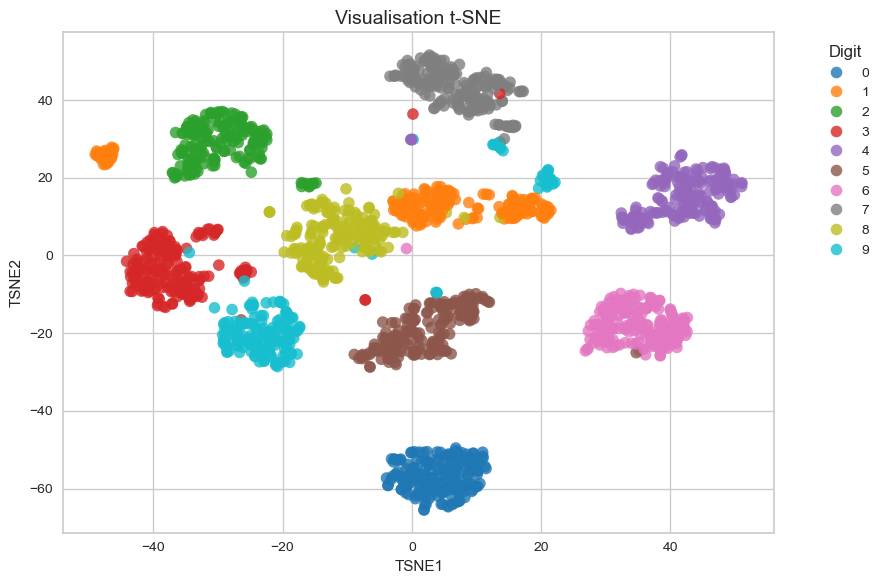

In [43]:
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()